Stock Market
=============

Step 1: Define a function to access Yahoo Finance API and extract the information for the stocks and dates requered, then store them as a csv file in the stock directory.

In [4]:
import yahoo_finance
import csv
import os.path

columns = ['volume','symbol','adj_close','high','low','date','close','open']

def stock_dl(symbol,start,end):
    for j in symbol:
        filepath = "stock/{}.csv".format(j)
        if not os.path.isfile(filepath): 
            
            stock = yahoo_finance.Share(j)
            history = stock.get_historical(start,end)
        
            with open(filepath, "w") as toWrite:
                writer = csv.writer(toWrite,delimiter=",")
                writer.writerow(columns)
                for i in history:
                    temp = []
                    for a in i.keys():
                        temp.append(i[a])
                    writer.writerow(temp)

Step 2: Run the previous function suplying the needed parameters. We will check major Tech companies and the SPY as baseline, use 5 years of data.

In [5]:
symbols = ['SPY','GOOGL','AAPL','TSLA','FB','MSFT']
start = '2011-09-22'
end = '2016-09-22'

stock_dl(symbol=symbols,start=start,end=end)

Step 3: Read csv files and store as pandas data frames, select subsets of data if needed.

In [6]:
import os
import pandas as pd

def symbol_to_path(symbol,base_dir="stock"):
    return os.path.join(base_dir,"{}.csv".format(str(symbol)))

def get_data(symbols,columns,start,end):
    dates = pd.date_range(start,end)
    df = pd.DataFrame(index=dates)
    
    for symbol in symbols:
        df_temp = pd.read_csv(symbol_to_path(symbol),index_col='date',parse_dates=True,
                              usecols=columns,na_values=['nan'])
        for i in columns:
            df_temp = df_temp.rename(columns={i:symbol+'_'+i})
        df = df.join(df_temp,how='left')
    
    df = df.dropna(subset=['SPY_adj_close'])
    
    return df
            
columns = ['adj_close','date']    
df = get_data(symbols=symbols,columns=columns,start=start,end=end)
print df.tail()
print "\nThe df is {} rows by {} columns".format(df.shape[0],df.shape[1])

            SPY_adj_close  GOOGL_adj_close  AAPL_adj_close  TSLA_adj_close  \
2016-09-15     214.197992       801.229980      115.570000      200.419998   
2016-09-16     213.369995       797.969971      114.919998      205.399994   
2016-09-19     213.410004       795.390015      113.580002      206.339996   
2016-09-20     213.419998       799.780029      113.570000      204.639999   
2016-09-21     215.820007       805.030029      113.550003      205.220001   

            FB_adj_close  MSFT_adj_close  
2016-09-15    128.350006       57.189999  
2016-09-16    129.070007       57.250000  
2016-09-19    128.649994       56.930000  
2016-09-20    128.639999       56.810001  
2016-09-21    129.940002       57.759998  

The df is 1258 rows by 6 columns


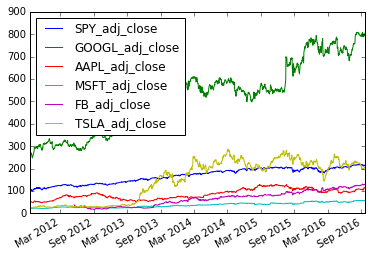

In [7]:
%matplotlib inline
import matplotlib.pyplot as plt

df[['SPY_adj_close','GOOGL_adj_close','AAPL_adj_close','MSFT_adj_close','FB_adj_close','TSLA_adj_close']].plot()
plt.show()

Stock exchange often has 252 trading days per year, just a reminder.

Step 4: Normalize data, that is make it all start at 1.0 value. So you know, equality and stuff.

In [8]:
ndf = df/df.ix[0,:]
# ndf = ndf.ix[:,range(0,len(ndf.columns.values),2)] #Used when including "close"
ndf.head()

SPY_adj_close  GOOGL_adj_close  AAPL_adj_close  TSLA_adj_close  \
2011-09-22       1.000000         1.000000        1.000000        1.000000   
2011-09-23       1.006025         1.009315        1.006172        1.029263   
2011-09-26       1.029949         1.021569        1.003360        0.995708   
2011-09-27       1.041467         1.035878        0.993629        1.021849   
2011-09-28       1.020202         1.015711        0.988029        0.959423   

            FB_adj_close  MSFT_adj_close  
2011-09-22           NaN        1.000000  
2011-09-23           NaN        1.000000  
2011-09-26           NaN        1.015164  
2011-09-27           NaN        1.024342  
2011-09-28           NaN        1.020750

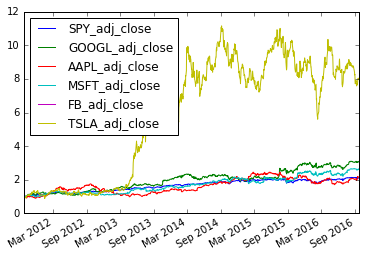

In [9]:
ndf[['SPY_adj_close','GOOGL_adj_close','AAPL_adj_close','MSFT_adj_close','FB_adj_close','TSLA_adj_close']].plot()
plt.show()

But what happened to FB? Since it had a NaN value in the position 0, we cannot visualize it normalized (yet at least). We include Google and Tesla which were not included last time. Wow Tesla, wow.

Lets fill the missing information of FB, first filling backward, then forward.

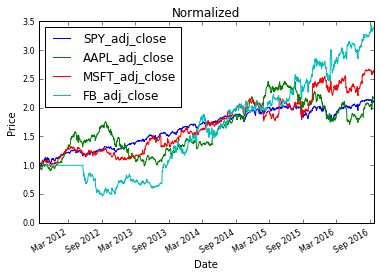

In [10]:
df.fillna(method='ffill',inplace='TRUE')
df.fillna(method='bfill',inplace='TRUE')
ndf = df/df.ix[0,:]

ax = ndf[['SPY_adj_close','AAPL_adj_close','MSFT_adj_close','FB_adj_close']].plot(title='Normalized',fontsize=8)
ax.set_xlabel('Date')
ax.set_ylabel('Price')
plt.show()

Step 5: Rocking & Rolling statistics...

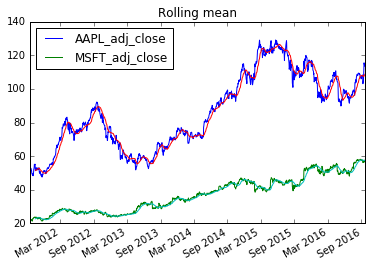

In [11]:
rmdf = df.rolling(window=20,center=False).mean()

ax = df[['AAPL_adj_close','MSFT_adj_close']].plot(title='Rolling mean')
rmdf['AAPL_adj_close'].plot()
rmdf['MSFT_adj_close'].plot()
#rmdf[['AAPL_adj_close','MSFT_adj_close']].plot(ax=ax)
plt.show()

Step 6: Calculate Bollinger Bands(R), Bollinger bands are the "rolling confidence interval" being the rolling mean +- 2 times the rolling std.

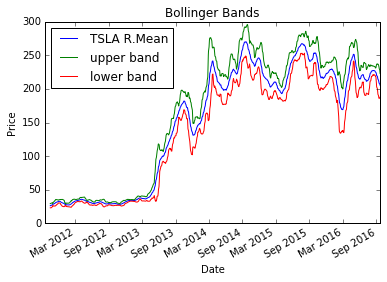

In [12]:
rsdf = df.rolling(window=20,center=False).std()
upperband = rmdf+2*rsdf
lowerband = rmdf-2*rsdf

ax = rmdf['TSLA_adj_close'].plot(label='TSLA R.Mean',title='Bollinger Bands')
upperband['TSLA_adj_close'].plot(label='upper band',ax=ax)
lowerband['TSLA_adj_close'].plot(label='lower band',ax=ax)
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax.legend(loc='upper left')
plt.show()

Step 7: Check for daily returns and cummulative returns.

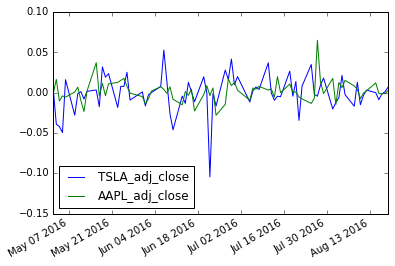

In [13]:
def time_slice(df,start,end):
    start = df.index.searchsorted(start)
    end = df.index.searchsorted(end)
    return df.ix[start:end]

dailyReturns = ndf.copy()
dailyReturns[1:] = (df[1:]/df[:-1].values)-1
dailyReturns.ix[0,:] = 0

time_slice(dailyReturns[['TSLA_adj_close','AAPL_adj_close']],'2016-05-01','2016-08-20').plot()
plt.show()

In [14]:
def cum_ret(df,symbol,start,end):
    temp = time_slice(df[symbol],start,end)
    return (temp.ix[-1]/temp.ix[0])-1

print cum_ret(ndf,'AAPL_adj_close','2016-05-01','2016-08-20')

0.181352708468


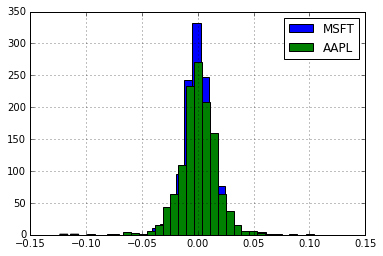

In [15]:
dailyReturns['MSFT_adj_close'].hist(bins=30,label="MSFT")
dailyReturns['AAPL_adj_close'].hist(bins=30,label="AAPL")
plt.legend(loc='upper right')
plt.show()

Compare two stocks against each other in a scatter plot.

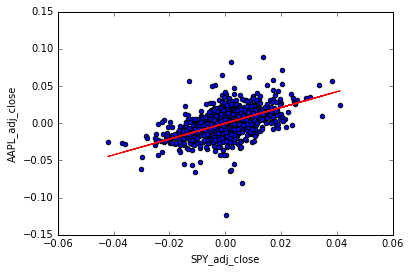

In [18]:
import numpy as np

def fitpol(df,symbol1,symbol2,n=1):
    return np.polyfit(df[symbol1],df[symbol2],n)

beta, alpha = fitpol(ndf,'SPY_adj_close','AAPL_adj_close') #mx + b

dailyReturns.plot(kind='scatter',x='SPY_adj_close',y='AAPL_adj_close')
plt.plot(dailyReturns['SPY_adj_close'],beta*dailyReturns['SPY_adj_close'],'-',color='r') #ALPHA?
plt.show()

Define a function to check the main global statistics for each stock.

In [31]:
def stats(df):
    temp = pd.DataFrame(index=df.columns.values,columns=['mean','std','kurtosis'])
    temp.ix[:,0] = df.mean()
    temp.ix[:,1] = df.std()
    temp.ix[:,2] = df.kurtosis()
    return temp

print stats(time_slice(dailyReturns,'2016-01-01','2016-08-20'))

                     mean       std   kurtosis
SPY_adj_close    0.000541  0.009210   1.696868
GOOGL_adj_close  0.000267  0.013838   2.290440
AAPL_adj_close   0.000477  0.016316   4.077889
TSLA_adj_close  -0.000037  0.026979   2.230555
FB_adj_close     0.001234  0.020199  21.610050
MSFT_adj_close   0.000492  0.016027   3.502898


# Portfolios

Where we analyse more than one stock at a time.

Step 9: Allocate a portfolio (choose which and how much).
- Take stock price df
- Normalize it
- Select allocations (sum = 1.0)
- Get a huge amount of money to invest, multiply it by allocation
- We are interested in Deltas!

In [148]:
amount = 1000000
allocation = pd.DataFrame(columns=ndf.columns.values,index=['allocation'])
allocation.ix[0,:] = [.1,.1,.2,.1,.2,.3]
port_val = np.sum(allocation*amount,axis=1)
print "Current portfolio value: {}".format(port_val.values[0])

def portVal(df,amount,allocation,start,end):
    df = time_slice(df,start,end)
    value = df/df.ix[df.index.searchsorted(start)]
    #return np.dot(value*amount,np.transpose(allocation.values))
    return np.sum(np.multiply(value,allocation.values),axis=1)*amount

pval = portVal(df,amount,allocation,'2016-05-01','2016-08-20')
#print "Future portfolio value: {}".format(round(pval[0][0],1)) #ok?
print 'Future portfolio value: {}'.format(round(pval.ix[-1],1))

Current portfolio value: 1000000.0
Future portfolio value: 1101385.8
